# Exploring Los Angeles County Cities: Identifying 'Quiet' Areas

## 1. Discussion and Background of the Business Problem:

### 1.1 Problem Statement: Prospects of Relatively 'Quiet' Cities in the Surrounding Los Angeles Area

Los Angeles is the largest city in the state of California. It has an estimated population of nearly four million people making it tough to find 'quiet' places that lack cultural noise.

### 1.2 Target Audience

What type of clients or a group of people would be interested in this project?

- Business Owners
- Prospective Home Owners
- Seismic Sensor Installers

### 1.3 Data Description

Data will be collected from the following sources:
- Los Angeles county city data that contains **city name**, and **population**.<br>
     *Data Source:* [Wikipedia](https://en.wikipedia.org/wiki/List_of_cities_in_Los_Angeles_County,_California)
- Los Angeles county city data that contains **land area** in square miles.<br>
     *Data Source:* [Census.gov](https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2017_Gazetteer/2017_gaz_place_06.txt)
- Coordinate data for the cities in Los Angeles county which includes **latitude** and **longitude**.<br>
     *Data Source:* The Geocoder Python library
- The number of retail establishments will be fetched using the Foursquare API.<br>
     *Data Source:* Foursquare API

### 1.4 Approach

The approach to resolve the issue of identifying the most quiet areas in Los Angeles county is as follows:

- Collect Los Angeles county city data from Wikipedia.
- Utilize the Geocoder Python library to collect city coordinate data.
- Use the Foursquare API to get the approximate number of retail establishments in each City.
- Preprocess the data
- Visualize the data and do some statistical analysis.
- Analyzing by using Clustering (K-Means).
- Find the best value for K.
- Visualize the city max density of population.
- Visualize the city max density of retail establishments.
- From results, infer which areas would be the quietest and draw conclusions.

## 2. Data Preparation:

### 2.1 Scraping Los Angeles County Cities from Wikipedia

In [2]:
# https://towardsdatascience.com/exploring-the-tokyo-neighborhoods-data-science-in-real-life-8b6c2454ca16
# https://towardsdatascience.com/classification-of-moscow-metro-stations-using-foursquare-data-fb8aad3e0e4
# https://ruddra.com/posts/project-battle-of-capstones/

import pandas as pd
import numpy as np

import re

# A List of Cities in Los Angeles County, California
wiki_link = "https://en.wikipedia.org/wiki/List_of_cities_in_Los_Angeles_County,_California"

Pandas provides a method for reading html directly into a DataFrame.

In [129]:
# Read the wikipedia tables into dataframes
dfs = pd.read_html(wiki_link)
# the first DF contains city data
df = dfs[0]
df.columns

Index(['City', 'Date incorporated', 'Population as of(2010 Census)'], dtype='object')

### 2.2 Clean the City Data

Now that the data is obtained, we must clean it up a bit. The date the city was incorporated will be of no use to us during analysis. We should also rename the Population column so it is more easily accessed.  

In [130]:
# Date Incorporated is useless
df = df.drop(['Date incorporated'], axis=1)

# Rename Population Column
df = df.rename(columns={'Population as of(2010 Census)':'Population'})
df.head()

,City,Population
0,Agoura Hills,20330
1,Alhambra,83653
2,Arcadia,56364
3,Artesia,16522
4,Avalon,3728


### 2.3 Obtaining Coordinate Data

In [131]:
import geocoder

We will use the ArcGIS provider, as it seems to be the most reliable.

In [132]:
def get_lat_lon(city):
    print('Trying to get coordinates for {}'.format(city))
    lat_lon = None
    while not lat_lon:
        geo_str = '{}, Los Angeles County, California'.format(city)
        g = geocoder.arcgis(geo_str)
        lat_lon = g.latlng
    print('Successfully got coordinates for {}'.format(city))
    return lat_lon

Use the applymap function to send each City to the get_lat_lon function. Please be patient, this may take well over 1 minute to obtain all the coordinates.

In [133]:
lat_lon_df = df[['City']].applymap(get_lat_lon)

Trying to get coordinates for Agoura Hills
Successfully got coordinates for Agoura Hills
Trying to get coordinates for Alhambra
Successfully got coordinates for Alhambra
Trying to get coordinates for Arcadia
Successfully got coordinates for Arcadia
Trying to get coordinates for Artesia
Successfully got coordinates for Artesia
Trying to get coordinates for Avalon
Successfully got coordinates for Avalon
Trying to get coordinates for Azusa
Successfully got coordinates for Azusa
Trying to get coordinates for Baldwin Park
Successfully got coordinates for Baldwin Park
Trying to get coordinates for Bell
Successfully got coordinates for Bell
Trying to get coordinates for Bell Gardens
Successfully got coordinates for Bell Gardens
Trying to get coordinates for Bellflower
Successfully got coordinates for Bellflower
Trying to get coordinates for Beverly Hills
Successfully got coordinates for Beverly Hills
Trying to get coordinates for Bradbury
Successfully got coordinates for Bradbury
Trying to ge

Successfully got coordinates for Bellflower
Trying to get coordinates for Beverly Hills
Successfully got coordinates for Beverly Hills
Trying to get coordinates for Bradbury
Successfully got coordinates for Bradbury
Trying to get coordinates for Burbank
Successfully got coordinates for Burbank
Trying to get coordinates for Calabasas
Successfully got coordinates for Calabasas
Trying to get coordinates for Carson
Successfully got coordinates for Carson
Trying to get coordinates for Cerritos
Successfully got coordinates for Cerritos
Trying to get coordinates for Claremont
Successfully got coordinates for Claremont
Trying to get coordinates for Commerce
Successfully got coordinates for Commerce
Trying to get coordinates for Compton
Successfully got coordinates for Compton
Trying to get coordinates for Covina
Successfully got coordinates for Covina
Trying to get coordinates for Cudahy
Successfully got coordinates for Cudahy
Trying to get coordinates for Culver City
Successfully got coordina

Make sure the shape of this DF matches the original and we know from [Wikipedia](https://en.wikipedia.org/wiki/List_of_cities_in_Los_Angeles_County,_California) that there are 88 cities in the county.

In [134]:
lat_lon_df.shape

(88, 1)

We now will insert the latitude and longitude values into the original DataFrame.

In [135]:
df['Latitude'] = lat_lon_df.City.map(lambda x: x[0])
df['Longitude'] = lat_lon_df.City.map(lambda x: x[1])
df.head()

,City,Population,Latitude,Longitude
0,Agoura Hills,20330,34.14611,-118.77812
1,Alhambra,83653,34.09370,-118.12727
2,Arcadia,56364,34.13614,-118.03887
3,Artesia,16522,33.86114,-118.07968
4,Avalon,3728,33.34411,-118.32139


In [136]:
# Save current DataFrame as CSV so we don't have to hit the web again.
df.to_csv('la_cities_latlon.csv', index=False)
#df = pd.read_csv('la_cities_latlon.csv')

### 2.3 Obtaining Surface Area Data

A description of the columns found in the data from census.gov can be found [here](https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/gaz18-record-layouts.html)

In [137]:
surf_area_link = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_gaz_place_06.txt'
# encoding parameter is needed to overcome a read issue
data = pd.read_csv(surf_area_link, sep='\t', encoding='latin-1')

In [138]:
# well that was easier than expected!
data.head()

,USPS,GEOID,ANSICODE,NAME,LSAD,FUNCSTAT,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,CA,600135,2582926,Acalanes Ridge CDP,57,S,1193072,0,0.461,0.000,37.904722,-122.078574
1,CA,600156,2629758,Acampo CDP,57,S,2428474,0,0.938,0.000,38.173529,-121.279892
2,CA,600212,2407697,Acton CDP,57,S,101679344,60418,39.259,0.023,34.496070,-118.183897
3,CA,600296,2409663,Adelanto city,25,A,137024204,34740,52.905,0.013,34.580902,-117.439458
4,CA,600310,2582927,Adin CDP,57,S,8901691,15858,3.437,0.006,41.199312,-120.956779


In [139]:
# save out CSV so we have it stored
data.to_csv('surf_area_notcleaned.csv', index=False)

In [140]:
# Drop values that have 'CDP'
data = pd.read_csv('surf_area_notcleaned.csv')
dropped_cdp = data.drop(data.loc[data.NAME.str.contains('CDP')].index, axis='index')

# Remove 'city' that tails many values
dropped_cdp.NAME = dropped_cdp.NAME.map(lambda x: x.rstrip(' city'))

dropped_cdp.rename(columns={'NAME':'City', 'ALAND_SQMI':'Land_Area_sqmi'}, inplace=True)
dropped_cdp.reset_index(inplace=True)

In [141]:
result = pd.merge(df, dropped_cdp[['City', 'Land_Area_sqmi', 'ALAND']], on='City')

In [142]:
result.shape

(78, 6)

We see that we are missing 10 rows. Do these rows exist in 'dropped_cdp' ?

In [143]:
df[(~df.City.isin(result.City))]

,City,Population,Latitude,Longitude
11,Bradbury,1048,34.14531,-117.97094
16,Claremont,34926,34.09641,-117.71640
20,Cudahy,23805,33.95983,-118.17602
21,Culver City,38883,34.02161,-118.39621
23,Downey,111772,33.94077,-118.12768
35,Industry,219,34.02336,-117.95661
38,La Cañada Flintridge,20246,34.20766,-118.20725
59,Paramount,54098,33.88516,-118.16140
80,Temple City,35558,34.10728,-118.05668
83,Walnut,29172,34.02693,-117.84050


We can see that at least 4 of these Cities do exist but were not merged. We will forget about them for now.

In [144]:
dropped_cdp.loc[dropped_cdp.City.str.contains('Paramount|Bradbury|Claremont|Cudahy|Culver|Downey|Industry|Flintridge|Temple|Walnut', flags=re.IGNORECASE)]

,index,USPS,GEOID,ANSICODE,City,LSAD,FUNCSTAT,ALAND,AWATER,Land_Area_sqmi,AWATER_SQMI,INTPTLAT,INTPTLONG
100,327,CA,617568,2410276,Culver C,25,A,13237050,72217,5.111,0.028,34.005820,-118.396781
202,677,CA,639003,2411565,La CaÃ±ada Flintridge,25,A,22341706,44361,8.626,0.017,34.209690,-118.200139
431,1355,CA,678148,2412047,Temple C,25,A,10371371,0,4.004,0.000,34.102159,-118.057949
454,1440,CA,683346,2412174,Walnut Creek,25,A,51169190,31195,19.757,0.012,37.902666,-122.040479


### 2.3 Obtaining LA Venue Data

In [147]:
import folium

import requests

import geocoder

Use geocoder with the ArcGIS provider to get the address of Los Angeles, CA.

In [148]:
address = 'Los Angeles, CA'

g = geocoder.arcgis(address)
lat = g.latlng[0]
lon = g.latlng[1]

df_orig = df.copy() # Just in case...
df = result # For convenience

In [149]:
print('The geographical coordinates of Los Angeles, CA are {}, {}.'.format(lat, lon))

The geographical coordinates of Los Angeles, CA are 34.05349000000007, -118.24531999999999.


Create a map of Los Angeles with cities superimposed on top.

In [150]:
map_la = folium.Map(location=g.latlng, zoom_start=9)

for lat, lon, city in zip(df['Latitude'], df['Longitude'], 
                          df['City']):
    label = '{}, Los Angeles'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                    radius=5,
                    popup=label,
                    color='blue',
                    fill=True,
                    fill_color='#3186cc',
                    fill_opacity=0.7,
                    parse_html=False).add_to(map_la)

map_la

Need to specify Foursquare credentials to get the data through their API.

In [1]:
CLIENT_ID = 'your-client-id' # your Foursquare ID
CLIENT_SECRET = 'your-secret' # your Foursquare Secret
VERSION = '20200506' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your-client-id
CLIENT_SECRET:your-secret


Define a function to obtain venues that are nearby to the Cities. What is a good value for radius? Shouldn't this be made dynamically based on the area the city encompasses?

In [152]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    print('Getting venue list, this may take a while...')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            # how to get the only the primary category?
            v['venue']['categories'][0]['name']) for v in results])
                

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Use previously defined function to obtain a list of LA foursquare venues.

In [13]:
la_venues = getNearbyVenues(names=df['City'], 
                            latitudes=df['Latitude'],
                            longitudes=df['Longitude']
                       )
print('Done!')

Getting venue list, this may take a while...
Done!


Check the size and view the first few results.

In [153]:
print(la_venues.shape)
la_venues.head()

(2058, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agoura Hills,34.14611,-118.77812,Future Track Running Center,34.145819,-118.779251,Sporting Goods Shop
1,Agoura Hills,34.14611,-118.77812,Twisted Oak Tavern,34.145308,-118.778679,Gastropub
2,Agoura Hills,34.14611,-118.77812,Grissini Ristorante,34.145815,-118.778534,Italian Restaurant
3,Agoura Hills,34.14611,-118.77812,Cafe Bizou,34.148410,-118.782587,French Restaurant
4,Agoura Hills,34.14611,-118.77812,Pizza Nosh,34.148311,-118.782181,Pizza Place


In [15]:
len(la_venues['Venue Category'].unique())

270

We are interested in the total count of venues for each City. We will Add the counts to our original DataFrame.

In [154]:
df = df.merge(la_venues.groupby('City').count()['Venue'].sort_values(ascending=True), on='City')

In [156]:
df.head()

,City,Population,Latitude,Longitude,Land_Area_sqmi,ALAND,Venue
0,Agoura Hills,20330,34.14611,-118.77812,7.801,20203991,18
1,Alhambra,83653,34.09370,-118.12727,7.631,19764227,43
2,Arcadia,56364,34.13614,-118.03887,10.925,28294900,1
3,Artesia,16522,33.86114,-118.07968,1.621,4197593,42
4,Avalon,3728,33.34411,-118.32139,2.883,7468050,57


We have now acquired and merged all data required for our analysis. We will save this DataFrame so we can skip the previous steps if things go wrong!

In [157]:
df.to_csv('la_ready_for_analysis.csv', index=False)

## 3. Preprocess the Data:

### 3.1 Preprocessing Purpose

We will now preprocess our data so we can make useful analysis. Our preprocessing will include the calculation of population density and venu density per land area for each of the cities. After calculating the densities, we will normalize using a MinMaxScaler from sklearn. This will ensure the densities are used equally when calculating clusters.

### 3.2 Load the Data

In [3]:
df = pd.read_csv('la_ready_for_analysis.csv')
print(df.shape)
df.describe()

(77, 7)


,Population,Latitude,Longitude,Land_Area_sqmi,ALAND,Venue
count,7.700000e+01,77.000000,77.000000,77.000000,7.700000e+01,77.000000
mean,1.098218e+05,34.012020,-118.197845,17.887039,4.632716e+07,26.727273
std,4.302547e+05,0.183215,0.224700,55.067444,1.426242e+08,19.115051
min,1.120000e+02,33.344110,-118.818750,0.948000,2.455587e+06,1.000000
25%,2.025600e+04,33.895690,-118.353740,3.577000,9.263209e+06,12.000000
50%,4.636100e+04,34.011580,-118.154940,7.236000,1.874171e+07,23.000000
75%,8.429300e+04,34.112980,-118.063700,13.472000,3.489115e+07,35.000000
max,3.792621e+06,34.698900,-117.750030,468.956000,1.214591e+09,95.000000


### 3.3 Calculate Densities

The population and venue density will be calculated in units per square mile from the columns **Land_Area_sqmi** and **Venue**.

In [167]:
df['Population_Density'] = df['Population'] / df['Land_Area_sqmi']
df['Venue_Density'] = df['Venue'] / df['Land_Area_sqmi']

df.head()

,City,Population,Latitude,Longitude,Land_Area_sqmi,ALAND,Venue,Population_Density,Venue_Density
0,Agoura Hills,20330,34.14611,-118.77812,7.801,20203991,18,2606.076144,2.307396
1,Alhambra,83653,34.09370,-118.12727,7.631,19764227,43,10962.259206,5.634910
2,Arcadia,56364,34.13614,-118.03887,10.925,28294900,1,5159.176201,0.091533
3,Artesia,16522,33.86114,-118.07968,1.621,4197593,42,10192.473782,25.909932
4,Avalon,3728,33.34411,-118.32139,2.883,7468050,57,1293.097468,19.771072


### 3.4 Normalize The Densities

When we calculate our clusters, we need to ensure Population Density isn't more heavily favored compared to Venue Density. To accomplish this, we will use a **MinMaxScaler** object from sklearn.

In [168]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_scaled = scaler.fit_transform(df[['Population_Density', 'Venue_Density']])

to_merge = pd.DataFrame(data_scaled, columns=['norm_Population_D', 'norm_Venue_D'])

df['norm_Population_D'] = to_merge['norm_Population_D']
df['norm_Venue_D'] = to_merge['norm_Venue_D']

df.head()

,City,Population,Latitude,Longitude,Land_Area_sqmi,ALAND,Venue,Population_Density,Venue_Density,norm_Population_D,norm_Venue_D
0,Agoura Hills,20330,34.14611,-118.77812,7.801,20203991,18,2606.076144,2.307396,0.111202,0.048539
1,Alhambra,83653,34.09370,-118.12727,7.631,19764227,43,10962.259206,5.634910,0.470871,0.120533
2,Arcadia,56364,34.13614,-118.03887,10.925,28294900,1,5159.176201,0.091533,0.221093,0.000596
3,Artesia,16522,33.86114,-118.07968,1.621,4197593,42,10192.473782,25.909932,0.437737,0.559202
4,Avalon,3728,33.34411,-118.32139,2.883,7468050,57,1293.097468,19.771072,0.054688,0.426382


## 4. Analyzing The Cities:

### 4.1 Cluster Neighborhoods

In [169]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

In [170]:
# set number of clusters
kclusters = 5 # How to calculate adequate number of clusters?

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df[['norm_Population_D', 'norm_Venue_D']])

kmeans.labels_[0:]

array([3, 2, 1, 4, 3, 1, 2, 2, 0, 2, 1, 1, 3, 1, 1, 3, 2, 1, 3, 3, 2, 3,
       2, 1, 3, 4, 2, 4, 3, 0, 2, 3, 1, 2, 3, 1, 3, 0, 2, 1, 1, 2, 3, 2,
       0, 3, 1, 1, 2, 3, 3, 1, 1, 1, 3, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2,
       3, 1, 1, 2, 2, 1, 3, 1, 0, 3, 1], dtype=int32)

In [171]:
df.insert(0, 'Cluster Labels', kmeans.labels_)

In [172]:
# create map
map_clusters = folium.Map(location=g.latlng, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['City'], df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4.2 Examine Clusters

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Lets take a quick look at how the clusters worked out:

In [197]:
df[['Population_Density', 'Venue_Density', 'Cluster Labels']].groupby('Cluster Labels').mean().T

Cluster Labels,0,1,2,3,4
Population_Density,18894.555647,6583.150868,11179.945239,2157.527527,12969.053547
Venue_Density,9.807719,2.339028,5.602873,3.731543,36.371024


Lets visualize the previous values. Not very pretty, but we can see what we need. We probably would want to avoid Cities in Cluster 0 and in Cluster 4 as they have the highest population and venue densities.

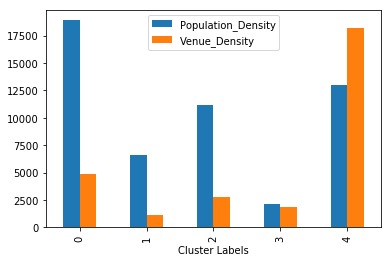

In [224]:
#df[['Population_Density', 'Venue_Density', 'Cluster Labels']].groupby('Cluster Labels').mean().unstack().plot.bar()
gb = df.groupby('Cluster Labels').mean()[['Population_Density', 'Venue_Density']]
gb['Venue_Density'] = gb['Venue_Density']*500
gb.plot.bar()

In [236]:
# create map
df_q = df.loc[df['Cluster Labels'].isin(['3', '1'])]
quiet_clusters = folium.Map(location=g.latlng, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_q['Latitude'], df_q['Longitude'], df_q['City'], df_q['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(quiet_clusters)

In [234]:
# create map
df_l = df.loc[df['Cluster Labels'].isin(['0', '2', '4'])]
loud_clusters = folium.Map(location=g.latlng, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_l['Latitude'], df_l['Longitude'], df_l['City'], df_l['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(loud_clusters)

In [239]:
quiet_clusters

In [238]:
loud_clusters

## 5. Conclusion:

In this study we used population counts, venue counts and land areas of cities in Los Angeles County, CA in an attempt to identify areas of low cultural noise. We obtained this data through python libraries to scape city information and the use of Foursquare's API to tie venue counts to each of the cities. Since we have no available data to target, we made the assumption that cities with low population density and low venue density were to be considered quiet. Under this assumption, we were able to identify five different clusters of cities in Los Angeles County and identified which of these would be best described as a quiet area. 